# Benchmarking Parquet-CPP

### MLH project in collaboration with G-Research to benchmark Parquet-CPP performance 

This repository contains reproducible code for benchmarking Parquet-CPP on multiple parameters, inorder to get an idea of its performance in regards to working with Machine Learning workloads. The inspiration for this came from the article: [How Good is Parquet for Wide Tables Really?](https://www.influxdata.com/blog/how-good-parquet-wide-tables/)

We quantify the metadata overhead of Apache Parquet files for storing thousands of columns, as well as space and decode time using parquet-cpp, implemented in C++.

It was drawn with the motivation to make parquet files with thousands, potentially tens of thousands, of columns efficient to read. 

Today reading such files is prohibitively expensive because fetching and parsing the metadata takes considerable time. The current serialization scheme for parquet metadata is both bloated and too object oriented to be parsed efficiently.


## Setting up the Project

To set up the project and build the necessary C++ files for benchmarking Parquet, we have a `setup.sh` script that automates the following steps:

1. Download the vcpkg repository from GitHub.
2. Install Apache Arrow and Parquet using vcpkg.
3. Configure the project using CMake.
4. Build the project.

Follow these steps to make the script executable and run it:

In [2]:
import os

# Make the setup.sh script executable
os.chmod("setup.sh", 0o755)

# Run the setup.sh script
os.system("./setup.sh")

vcpkg package management program version 2024-06-10-02590c430e4ed9215d27870138c2e579cc338772

See LICENSE.txt for license information.
Telemetry
---------
vcpkg collects usage data in order to help us improve your experience.
The data collected by Microsoft is anonymous.
You can opt-out of telemetry by re-running the bootstrap-vcpkg script with -disableMetrics,
passing --disable-metrics to vcpkg on the command line,
or by setting the VCPKG_DISABLE_METRICS environment variable.

Read more about vcpkg telemetry at docs/about/privacy.md
Applied user-wide integration for this vcpkg root.
CMake projects should use: "-DCMAKE_TOOLCHAIN_FILE=/home/putin/MLH/gresearch_parquet_benchmarking/vcpkg/scripts/buildsystems/vcpkg.cmake"
error: `vcpkg install` requires a list of packages to install in classic mode.


Synopsis: Installs a package
Examples:
  vcpkg install <port name> <port name>...
  vcpkg install zlib zlib:x64-windows curl boost
See https://learn.microsoft.com/vcpkg/commands/install for more information.
Options:
  --allow-unsupported    Continues with a warning on unsupported ports, rather than failing
  --x-asset-sources=...  Asset caching sources. See 'vcpkg help assetcaching'
  --binarysource=...     Binary caching sources. See 'vcpkg help binarycaching'
  --x-buildtrees-root=...
                         Buildtrees directory (experimental)
  --clean-after-build    Cleans buildtrees, packages and downloads after building each package
  --clean-buildtrees-after-build
                         Cleans buildtrees after building each package
  --clean-downloads-after-build
                         Cleans downloads after building each package
  --clean-packages-after-build
                         Cleans packages after building each package
  --downloads-root=...   Downloads directory 

256

Here's a breakdown of what the `setup.sh` script does:

1. **Download vcpkg**: The script clones the vcpkg repository from GitHub. vcpkg is a cross-platform package manager that simplifies the process of installing and managing C++ libraries.

2. **Install Apache Arrow and Parquet**: Using vcpkg, the script installs the Apache Arrow and Parquet libraries. These libraries provide the necessary tools and APIs for working with Parquet files in C++.

3. **Configure the project with CMake**: The script uses CMake to configure the project. CMake is a build system generator that helps manage the build process of the project. It generates the necessary build files based on the project's configuration.

4. **Build the project**: Finally, the script triggers the build process using the generated build files. This step compiles the C++ source files and links them with the required libraries, creating the executable for benchmarking Parquet.

By running the `setup.sh` script using Python's `os` module, as shown in the code snippet above, the entire setup process is automated. The script takes care of downloading the necessary dependencies, configuring the project, and building it.

After the script completes successfully, your project will be set up and ready for benchmarking Parquet using C++.

## Metadata Size and Decode Time

Parquet files include the metadata required to interpret the file. This metadata also instructs the reader to load only the portion of the file necessary to answer queries. 

The metadata is encoded in the Apache Thrift format, which requires Parquet readers to fetch and potentially examine the entire metadata footer before reading any content.

Figure(1500x600)


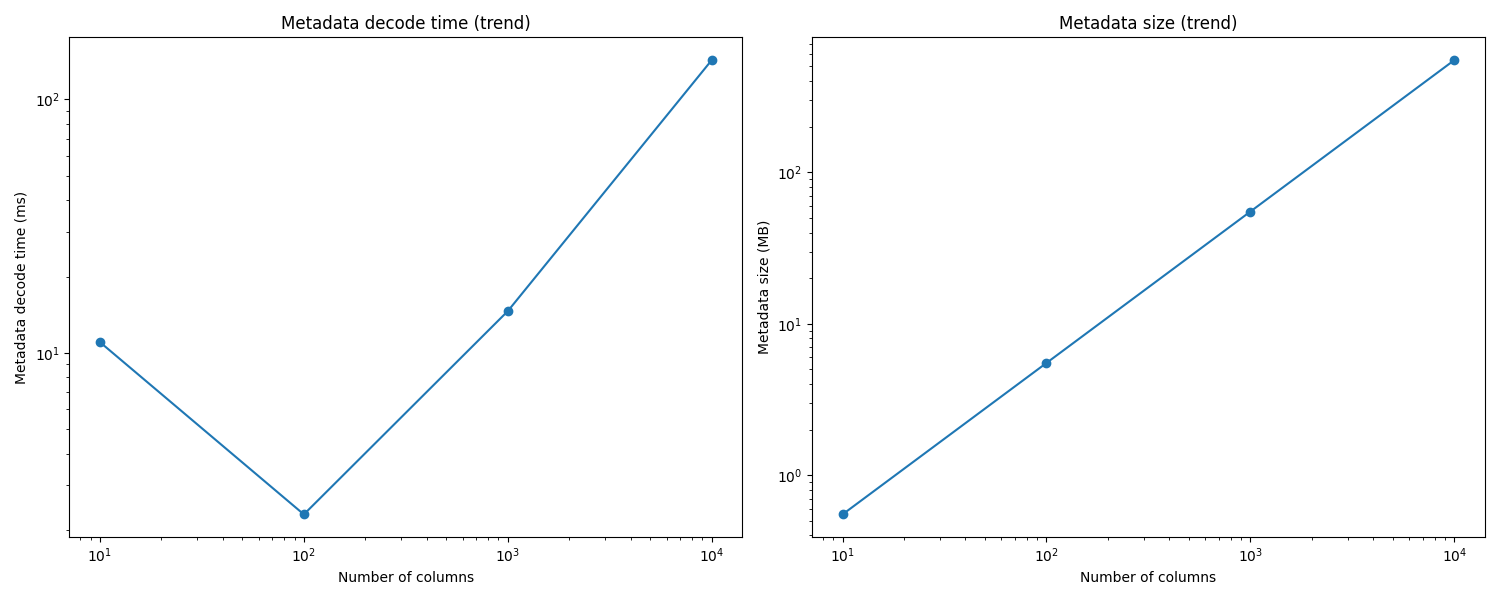

In [7]:
import os
from IPython.display import Image

# Compile and run the C++ benchmark program
os.system("./build/arrow_benchmarks")

# Run the Python script to visualize the benchmark results
os.system("python3 scripts/visualize_decode_and_size.py benchmark_decode_and_size.csv")

# Display the plot in the Jupyter Notebook
Image(filename='./temp/decode_and_size.png')

The plot shows the trends of metadata decode time and metadata size as the number of columns increases. Both the decode time and metadata size exhibit a logarithmic relationship with the number of columns, indicating that they grow sublinearly with the number of columns in the Parquet file.

This benchmark helps us understand how the metadata size and decode time scale with the number of columns in a Parquet file, which can be useful for optimizing Parquet file structures and reader performance.

## Paging, Chunking and Statistics

In [ ]:
import os
from IPython.display import Image

# Compile and run the C++ benchmark program
os.system("./build/metadata_benchmark")

# Run the Python script to visualize the benchmark results
os.system("python3 scripts/visualize_chunks_pages.py benchmark_chunks_and_pages.csv")
os.system("python3 scripts/visualize_stats.py benchmark_stats.csv")

### Chunks and Paging

In [ ]:
Image(filename='./temp/decode_and_size.png')

In [ ]:
Image(filename='./temp/decode_and_size.png')

In [ ]:
Image(filename='./temp/decode_and_size.png')

### Statistics

In [ ]:
Image(filename='./temp/decode_and_size.png')

In [ ]:
Image(filename='./temp/decode_and_size.png')

In [ ]:
Image(filename='./temp/decode_and_size.png')

## Compression Algorithms

In [ ]:
import os
from IPython.display import Image

# Compile and run the C++ benchmark program
os.system("./build/compression_benchmark")

# Run the Python script to visualize the benchmark results
os.system("python3 scripts/visualize_compression_benchmark.py")

In [1]:
from IPython.display import Image

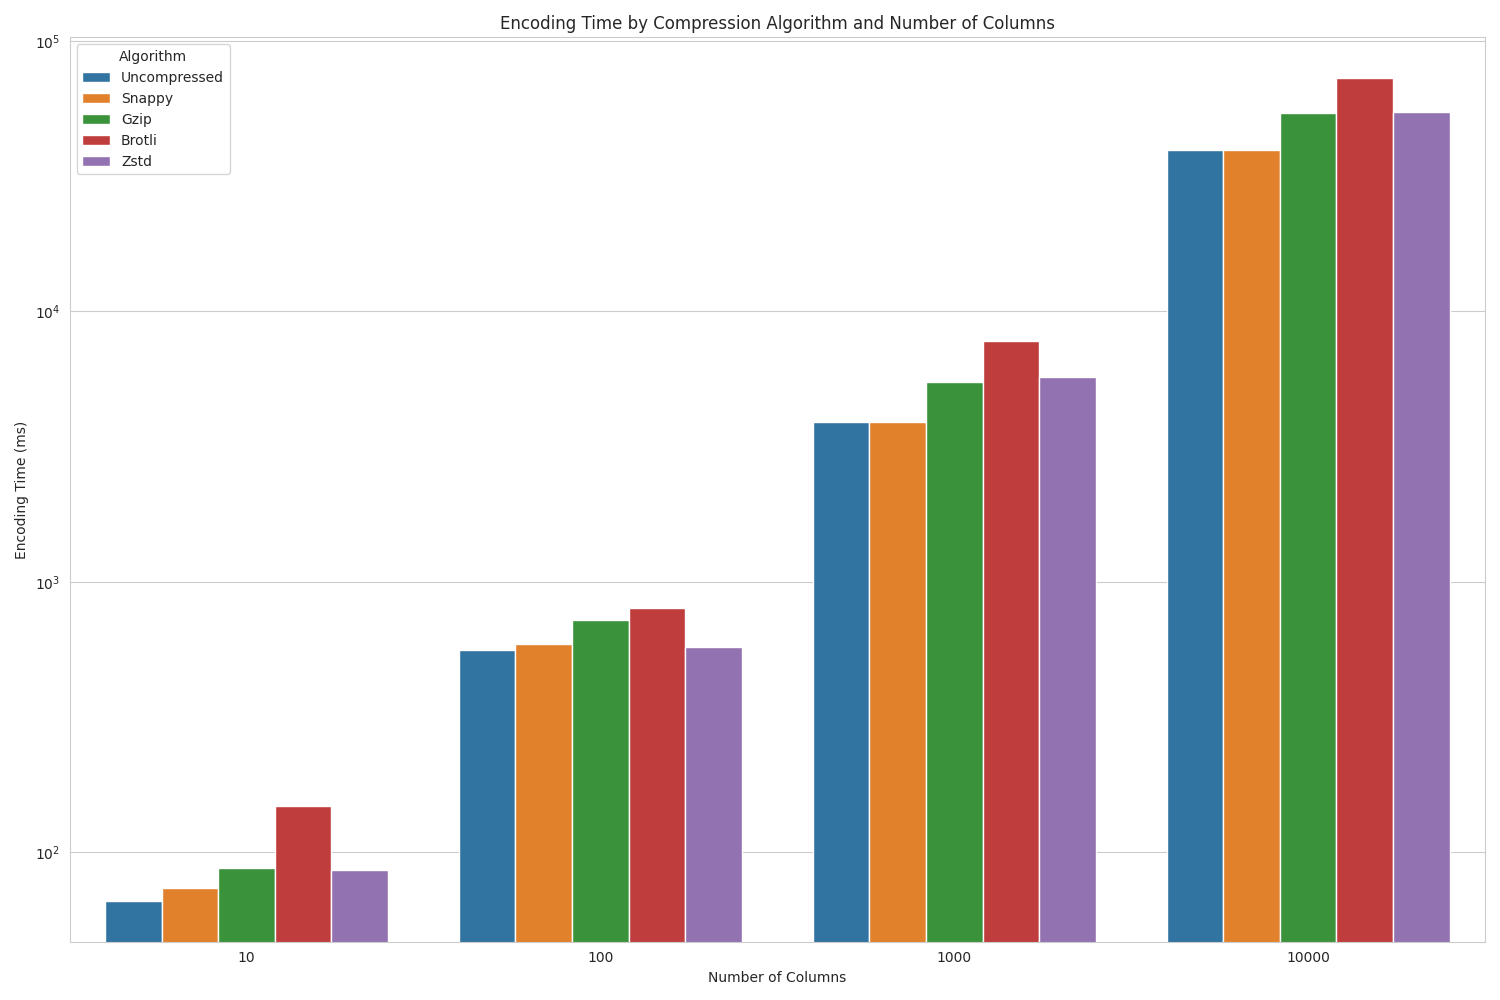

In [2]:
Image(filename='./temp/encoding_time.png')

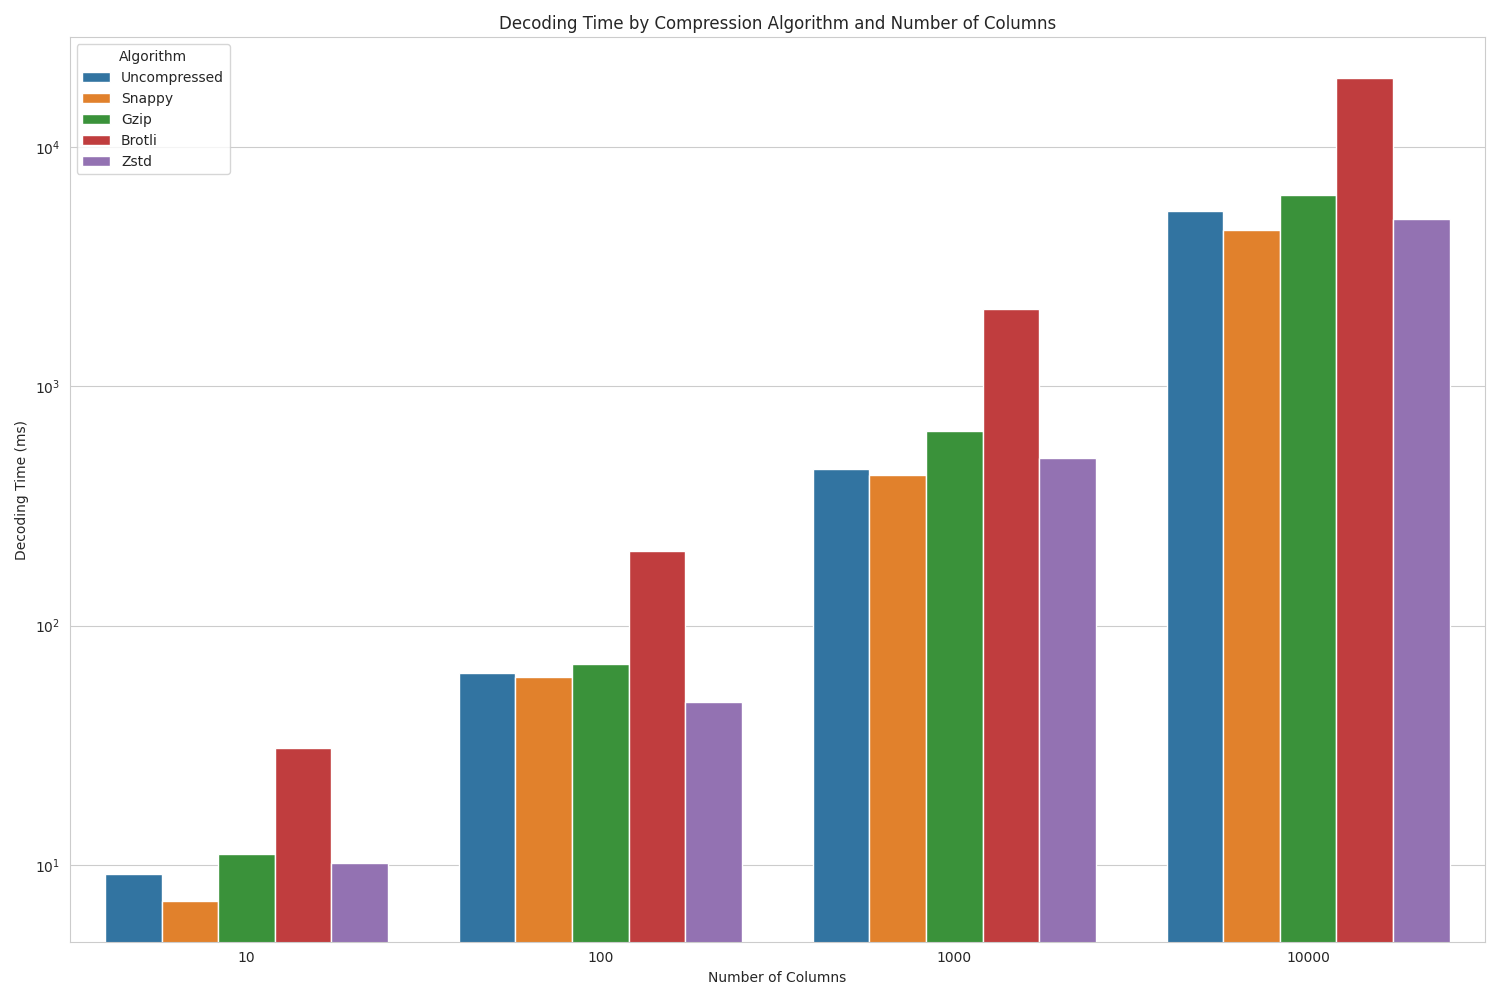

In [3]:
Image(filename='./temp/decoding_time.png')

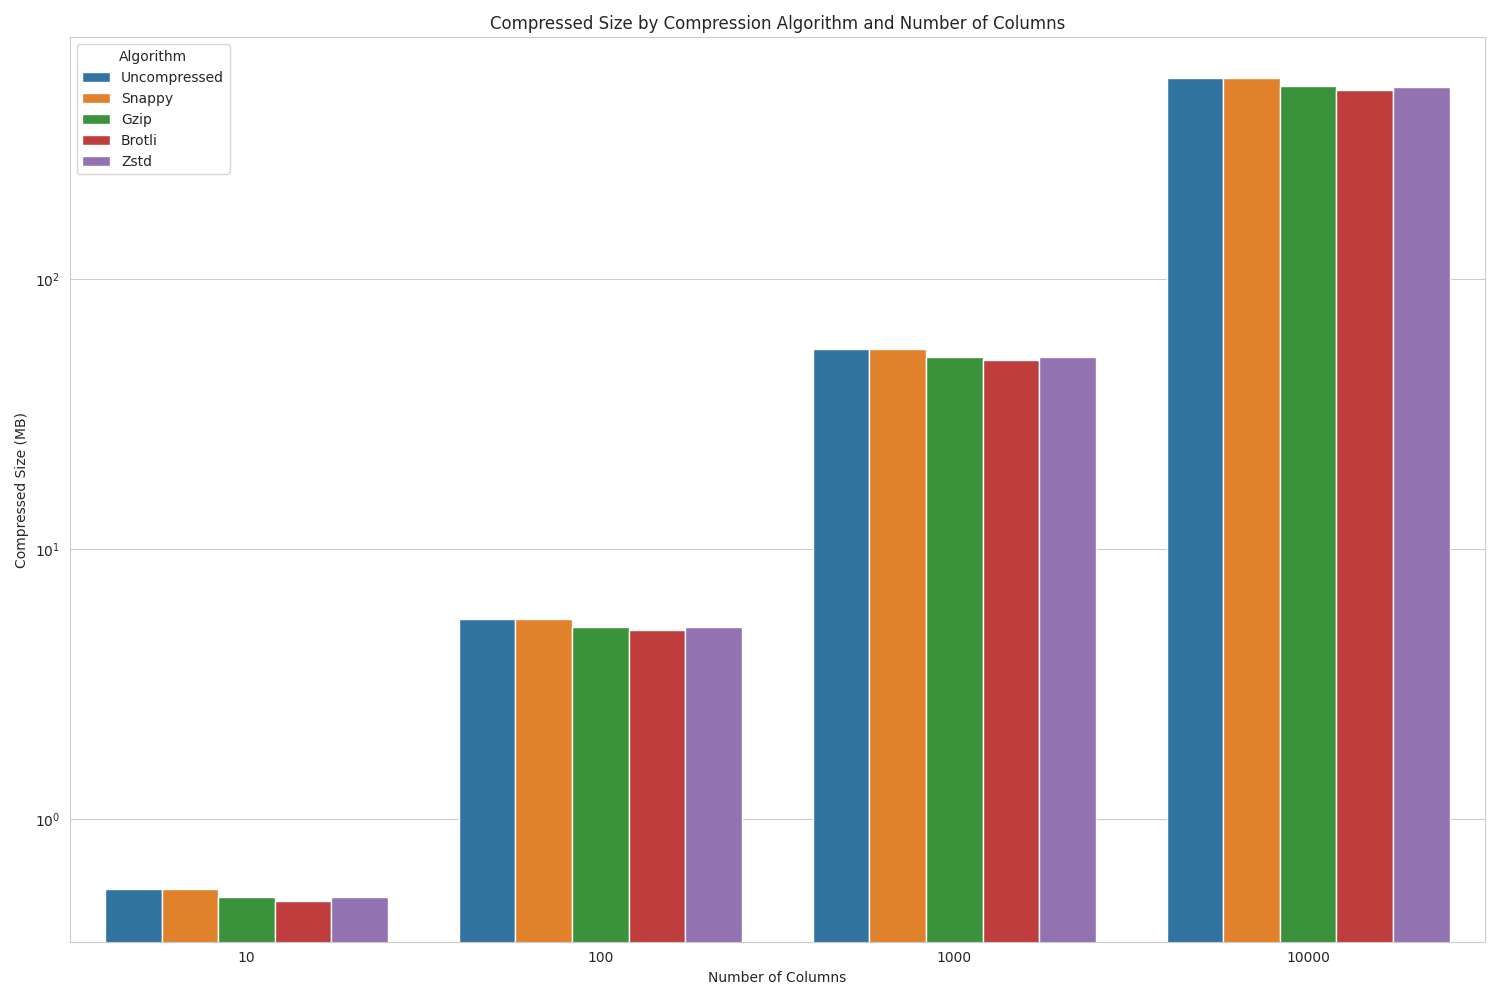

In [4]:
Image(filename='./temp/compressed_size.png')